This spreadsheet is a combination of two model data (N10 and B30 Pro), contains return data and some usage data.
For any cell that is empty, simply means no data available.

We need to predict the records with no data available whether they are return or not return based on records that are confirmed return.

In [10]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans # pip install scikit-learn
import re

In [11]:
# load the excel sheet into a Dataframe
xls = pd.ExcelFile("./UW_Churn_Pred_Data.xls")
print(f"Sheet Names: {xls.sheet_names}")

Sheet Names: ['Data', 'Legend', 'N10', 'B30 Pro', 'Data Before Feb 13']


In [12]:
# Load the Data Before Feb 13 sheet
data = pd.read_excel(xls, sheet_name="Data Before Feb 13")

In [13]:
# show the first 5 rows of the dataset
print(data.head())

   Device number Product/Model #     Month Office Date Office Time In  \
0      410006072             N10  December  2024-12-19       15:30:00   
1      410006130             N10       NaN         NaT            NaN   
2      410006155             N10       NaN         NaT            NaN   
3      410006171             N10       NaN         NaT            NaN   
4      410006213             N10       NaN         NaT            NaN   

       Source    Type Warranty Defect / Damage type  Responsible Party  \
0  B2C Amazon  Return      Yes            No defect  Customer: Remorse   
1         NaN     NaN      NaN                  NaN                NaN   
2         NaN     NaN      NaN                  NaN                NaN   
3         NaN     NaN      NaN                  NaN                NaN   
4         NaN     NaN      NaN                  NaN                NaN   

  Final Status  Churn                                           sim_info  \
0     Refurb B    1.0  [{"slot_index":0,

In [14]:
# Display basic info about the data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4995 entries, 0 to 4994
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Device number         4995 non-null   int64         
 1   Product/Model #       4995 non-null   object        
 2   Month                 275 non-null    object        
 3   Office Date           275 non-null    datetime64[ns]
 4   Office Time In        275 non-null    object        
 5   Source                275 non-null    object        
 6   Type                  269 non-null    object        
 7   Warranty              264 non-null    object        
 8   Defect / Damage type  264 non-null    object        
 9   Responsible Party     264 non-null    object        
 10  Final Status          263 non-null    object        
 11  Churn                 274 non-null    float64       
 12  sim_info              4884 non-null   object        
 13  promotion_email   

In [15]:
# check for duplicates
duplicates = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")

Number of duplicate rows: 0


In [16]:
# Check for duplicate device IDs
duplicate_devices = data['Device number'].duplicated().sum()
print(f"Number of duplicate devices: {duplicate_devices}")

Number of duplicate devices: 5


In [17]:
# Get all rows where 'Device number' is duplicated
duplicate_rows = data[data.duplicated(subset=['Device number'], keep=False)]

# Sort by 'Device number' to group duplicates together
duplicate_rows_sorted = duplicate_rows.sort_values('Device number')

# Display duplicates
print(duplicate_rows_sorted)

      Device number Product/Model #      Month Office Date Office Time In  \
3122      330020374         B30 Pro       June  2024-06-03       15:12:00   
3123      330020374         B30 Pro        NaN         NaT            NaN   
3262      330024475         B30 Pro       July  2024-07-29       14:15:00   
3263      330024475         B30 Pro     August  2024-08-15       15:45:00   
3774      330039895         B30 Pro       June  2024-06-12       07:40:00   
3775      330039895         B30 Pro       June  2024-06-25       07:55:00   
3943      330044952         B30 Pro     August  2024-08-19       14:50:00   
3944      330044952         B30 Pro  September  2024-09-24       07:50:00   
4144      330051296         B30 Pro        May  2024-05-20       07:45:00   
4145      330051296         B30 Pro       June  2024-06-13       13:45:00   

               Source    Type Warranty Defect / Damage type  \
3122  B2C NUU Website  Return      Yes            No defect   
3123              NaN     

Each duplicate represents a separate event (returns, repairs, registrations).
The Final Status and Office Date vary, indicating historical tracking. => keep all the rows

In [18]:
# check for missing values
print(f"Missing Values:\n{data.isnull().sum()}")

Missing Values:
Device number              0
Product/Model #            0
Month                   4720
Office Date             4720
Office Time In          4720
Source                  4720
Type                    4726
Warranty                4731
Defect / Damage type    4731
Responsible Party       4731
Final Status            4732
Churn                   4721
sim_info                 111
promotion_email         1820
register_email           111
interval_date            111
last_boot_date           111
active_date              111
dtype: int64


Only 249 out of 4495 records have a Churn value => most records are missing this key label => these missing values are what we need to predict

In [19]:
print(data['Churn'].value_counts())

Churn
1.0    249
0.0     25
Name: count, dtype: int64


In [20]:
categorical_features = data.select_dtypes(include=['object', 'bool']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)

categorical_features = ['Product/Model #', 'Month', 'Office Time In', 'Source', 'Type', 'Warranty', 'Defect / Damage type', 'Responsible Party', 'Final Status']

Categorical Features: ['Product/Model #', 'Month', 'Office Time In', 'Source', 'Type', 'Warranty', 'Defect / Damage type', 'Responsible Party', 'Final Status', 'sim_info', 'interval_date', 'last_boot_date', 'active_date']
Numerical Features: ['Device number', 'Churn', 'promotion_email', 'register_email']


# Analyzing Categorical Features

In [21]:
# Loop through categorical features and create crosstabs
for feature in categorical_features:
    print(f"--- {feature} ---")
    crosstab = pd.crosstab(data[feature], data['Churn'])
    print(crosstab)
    print("\n")

--- Product/Model # ---
Churn            0.0  1.0
Product/Model #          
B30                0    9
B30 Pro           24  110
N10                1  130


--- Month ---
Churn      0.0  1.0
Month              
April        0    6
August       5   18
December     2   63
February     1   31
January      1   53
July         5   13
June         2   48
May          2    6
November     1    4
October      5    3
September    1    4


--- Office Time In ---
Churn           0.0  1.0
Office Time In          
07:20:00          0    2
07:25:00          1    7
07:30:00          0    4
07:40:00          1   26
07:45:00          3   18
07:50:00          6   35
07:55:00          4    4
08:00:00          2   13
08:10:00          0    1
08:15:00          0    1
08:40:00          0    1
09:30:00          1    0
09:49:00          0    1
10:20:00          1    0
10:45:00          0    2
11:00:00          0    1
13:40:00          1    7
13:45:00          0    4
14:00:00          0    8
14:10:00          0 

In [22]:
features = ['Defect / Damage type','Final Status']
for col in features:
    print(f"--- {col} ---")
    print(data[col].value_counts(dropna=False))  # Includes NaN values in the count
    print("\n")

--- Defect / Damage type ---
Defect / Damage type
NaN                         4731
No defect                    234
Hardware                       9
Display or TP                  6
Device cannot power on         3
Camera                         2
Microphone/Speaker             2
Power (non battery)            2
LCD                            1
Receive/Transmit/Antenna       1
Software                       1
Buttons Physical               1
Battery                        1
Speaker                        1
Name: count, dtype: int64


--- Final Status ---
Final Status
NaN                                                   4732
Refurb B                                               141
Refurb A                                                60
New                                                     31
SBC                                                     12
Defective - Pending to repair and replacement sent       9
Send back to HK                                          4
Defective - P

--- Product/Model # ---
Product/Model #
N10        2632
B30 Pro    2354
B30           9
Name: count, dtype: int64


--- Source ---
Source
NaN                4720
B2C Amazon          178
B2C NUU Website      97
Name: count, dtype: int64


--- Type ---
Type
NaN       4726
Return     243
Repair      26
Name: count, dtype: int64


--- Warranty ---
Warranty
NaN    4731
Yes     256
No        8
Name: count, dtype: int64




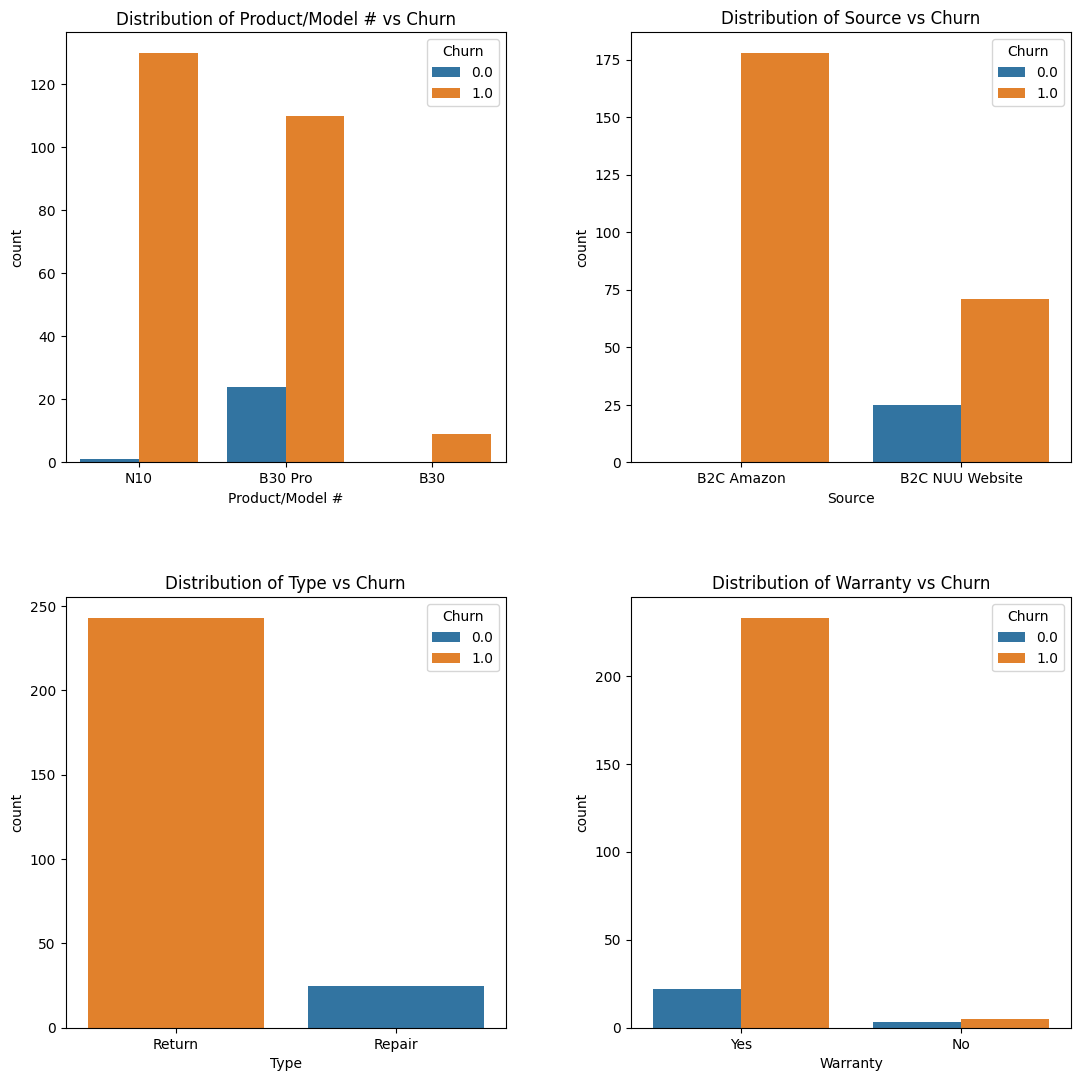

In [23]:
# List of categorical features to visualize
features = ['Product/Model #', 'Source', 'Type', 'Warranty']

for col in features:
    print(f"--- {col} ---")
    print(data[col].value_counts(dropna=False))  # Includes NaN values in the count
    print("\n")

# Create a figure with subplots
n_cols = 2  # Number of columns in the grid
n_rows = (len(features) + 1) // n_cols  # Calculate number of rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 12))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop through the features and plot each one
for i, col in enumerate(features):
    sns.countplot(data=data, x=col, hue='Churn', ax=axes[i])  # Plot on the i-th subplot
    axes[i].set_title(f'Distribution of {col} vs Churn')

# Remove empty subplots if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout(pad=5)
plt.show()

In [24]:
# Check the unique values in the Warranty column
print("Unique Warranty Values:\n", data['Warranty'].unique())

# Count how many churned devices had a warranty
churned_warranty_counts = data[data['Churn'] == 1]['Warranty'].value_counts(dropna=False)

print("\n### Warranty Status for Churned Devices (Churn = 1) ###")
print(churned_warranty_counts)

# Calculate the percentage of churned devices with and without warranty
total_churned = len(data[data['Churn'] == 1])
churned_with_warranty = churned_warranty_counts.get('Yes', 0)  # Adjust based on actual values in Warranty column
churned_without_warranty = churned_warranty_counts.get('No', 0)

print(f"\nPercentage of Churned Devices with Warranty: {churned_with_warranty / total_churned * 100:.2f}%")
print(f"Percentage of Churned Devices without Warranty: {churned_without_warranty / total_churned * 100:.2f}%")


Unique Warranty Values:
 ['Yes' nan 'No']

### Warranty Status for Churned Devices (Churn = 1) ###
Warranty
Yes    233
NaN     11
No       5
Name: count, dtype: int64

Percentage of Churned Devices with Warranty: 93.57%
Percentage of Churned Devices without Warranty: 2.01%


In [25]:
# Filter rows where Churn = 0 (non-returned)
non_returned = data[data['Churn'] == 0]

# Check the unique values and count in 'Type' for non-returned devices
print(non_returned['Type'].value_counts(dropna=False))

Type
Repair    25
Name: count, dtype: int64


Most of the confirmed non-return (Churn = 0) are repairs!

--- Month ---
Month
January      54
February     32
March         0
April         6
May           8
June         50
July         19
August       23
September     5
October       8
November      5
December     65
Name: count, dtype: int64




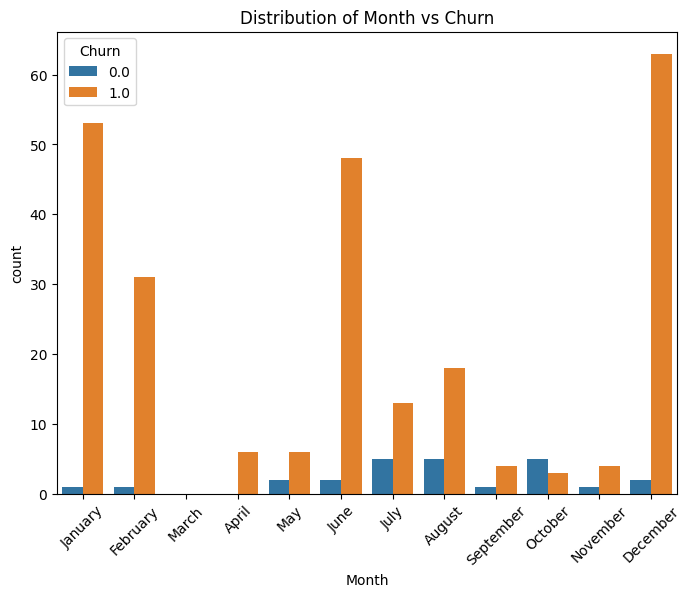

In [26]:
# Define the order of months
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

feature = 'Month'

# Convert the 'Month' column to a categorical type with the specified order
data[feature] = pd.Categorical(data[feature], categories=month_order, ordered=True)

# Print the value counts sorted by the defined month order
print(f"--- {feature} ---")
sorted_counts = data[feature].value_counts(dropna=False).reindex(month_order)
print(sorted_counts)
print("\n")

# Plotting the countplot
plt.figure(figsize=(8, 6))
sns.countplot(data=data, x=feature, hue='Churn')  # Color by Churn
plt.title(f'Distribution of {feature} vs Churn')
plt.xticks(rotation=45)
plt.show()

--- Responsible Party ---
Responsible Party
NaN                    4731
Customer: Remorse       232
Factory: Defective       14
Tested but No Issue       9
Customer: Damaged         8
Paid RMA                  1
Name: count, dtype: int64




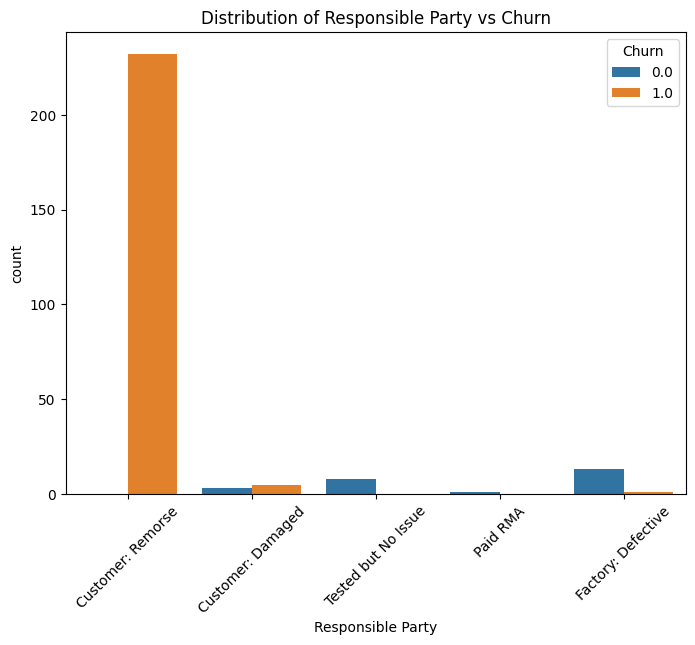

In [27]:
feature = 'Responsible Party'
# Display the count of unique values for each categorical feature
print(f"--- {feature} ---")
print(data[feature].value_counts(dropna=False))  # Includes NaN values in the count
print("\n")

plt.figure(figsize=(8, 6))
sns.countplot(data=data, x=feature, hue='Churn')  # Color by Churn
plt.title(f'Distribution of {feature} vs Churn')
plt.xticks(rotation=45)
plt.show()

--- Office Time In ---
Office Time In
NaN         4720
07:50:00      41
07:40:00      27
07:45:00      21
15:45:00      17
16:00:00      17
08:00:00      15
15:30:00       9
07:55:00       9
15:50:00       8
07:25:00       8
14:00:00       8
14:30:00       8
13:40:00       8
14:40:00       7
15:12:00       7
15:00:00       6
16:05:00       6
14:15:00       6
15:40:00       6
14:50:00       6
14:10:00       5
07:30:00       4
13:45:00       4
16:15:00       3
10:45:00       2
2:00 P.M       2
07:20:00       2
3:40 P.M       2
14:25:00       1
7:40 A.M       1
08:10:00       1
09:49:00       1
09:30:00       1
08:15:00       1
1230 PM        1
10:20:00       1
14:57:00       1
08:40:00       1
11:00:00       1
Name: count, dtype: int64




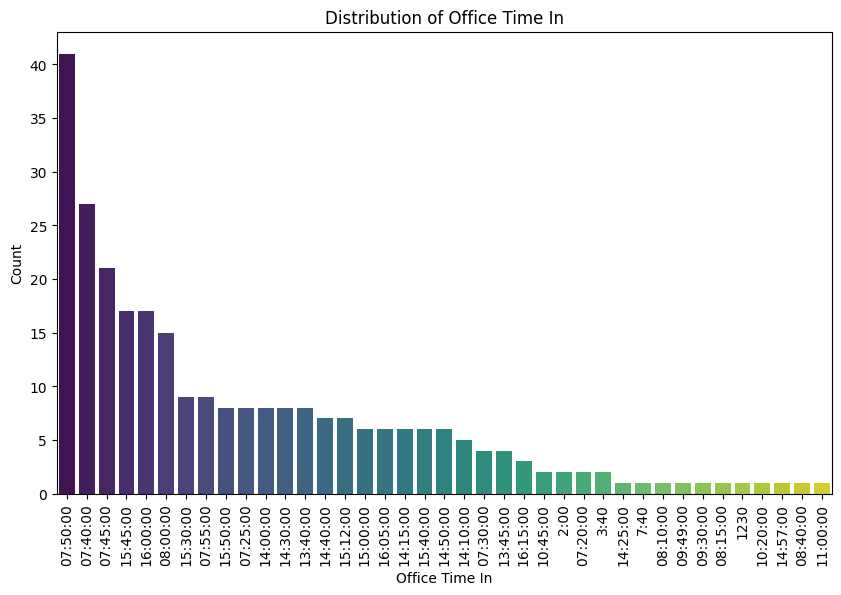

In [28]:
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=UserWarning, message="UnknownTimezoneWarning")
warnings.filterwarnings("ignore", category=FutureWarning)

feature = 'Office Time In'

print(f"--- {feature} ---")
print(data[feature].value_counts(dropna=False))  # Includes NaN values in the count
print("\n")

def clean_time_format(time_str):
    if isinstance(time_str, str):
        # Remove any timezone components (e.g., 'M' in '2:00 PM M')
        time_str = time_str.split(' ')[0]  # Keep only the time portion
        try:
            return datetime.strptime(time_str, '%I:%M %p').strftime('%H:%M:%S')
        except ValueError:
            return time_str  # Return original if it doesn't match expected format
    return time_str  # Return NaN as is

# Apply the cleaning function
data['Office Time In'] = data['Office Time In'].apply(clean_time_format)

# Plot the distribution of 'Office Time In'
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='Office Time In', order=data['Office Time In'].value_counts().index, palette='viridis')
plt.xticks(rotation=90)  # Rotate x-axis labels to avoid overlap
plt.title('Distribution of Office Time In')
plt.xlabel('Office Time In')
plt.ylabel('Count')
plt.show()

In [29]:
data['sim_info']

0       [{"slot_index":0,"carrier_name":"Emergency cal...
1                                              uninserted
2       [{"slot_index":1,"carrier_name":"T-Mobile","mc...
3       [{"slot_index":0,"carrier_name":"T-Mobile","mc...
4       [{"slot_index":0,"carrier_name":"Emergency cal...
                              ...                        
4990                                           uninserted
4991                                           uninserted
4992                                           uninserted
4993    [{"slot_index":0,"carrier_name":"T-Mobile","mc...
4994    [{"slot_index":0,"carrier_name":"T-Mobile","mc...
Name: sim_info, Length: 4995, dtype: object

--- Carrier Name ---
carrier_name
PERMISSION_DENIED    1707
T-Mobile             1375
uninserted            997
NaN                   111
HOME                   42
                     ... 
Jio True5G — JIO        1
LIME                    1
#QuedateEnCasa          1
Boost                   1
AT&T — LIBERTY          1
Name: count, Length: 195, dtype: int64


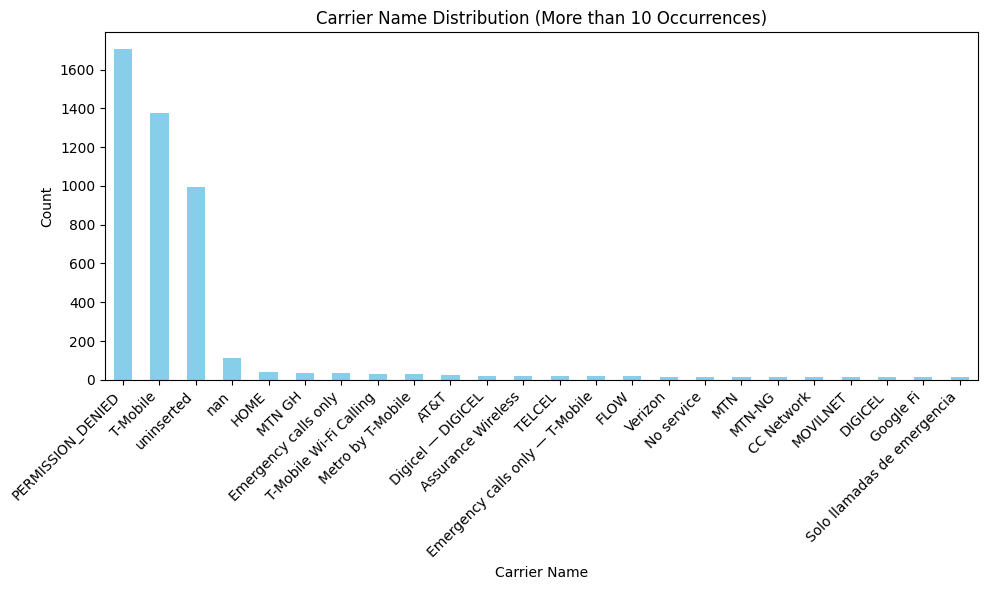

In [30]:
import json

# Function to parse carrier names
def extract_carrier_name(sim_info):
    try:
        # Check if the entry is a JSON string (sometimes it's just a plain string like 'uninserted')
        if isinstance(sim_info, str) and sim_info.startswith('[{'):
            # If it's a JSON string, load it into a Python list
            data = json.loads(sim_info)
            # Extract the carrier_name from the first item in the list (assuming it's the first slot)
            return data[0].get('carrier_name', 'Unknown')
        else:
            return sim_info  # return the raw string for cases like 'uninserted'
    except json.JSONDecodeError:
        return 'Invalid JSON'

# Apply the function to the 'sim_info' column
data['carrier_name'] = data['sim_info'].apply(extract_carrier_name)

# # Set Pandas to display more of the strings
# pd.set_option('display.max_colwidth', None)

# # Show the updated column
# print(data[['sim_info', 'carrier_name']].head())

# Count the occurrences of each carrier name
carrier_counts = data['carrier_name'].value_counts(dropna=False)

print(f"--- Carrier Name ---")
print(carrier_counts)

# Filter the carrier names with counts greater than 10
carrier_counts_filtered = carrier_counts[carrier_counts > 10]

# Plot the bar chart
plt.figure(figsize=(10, 6))
carrier_counts_filtered.plot(kind='bar', color='skyblue')
plt.title('Carrier Name Distribution (More than 10 Occurrences)')
plt.xlabel('Carrier Name')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [31]:
import json

# Function to classify sim_info into "inserted" or "uninserted"
def classify_sim_info(sim_info):
    # Check if sim_info is a JSON-like string
    if isinstance(sim_info, str) and sim_info != 'Unknown' and sim_info != '':
        try:
            # Try parsing the sim_info string as JSON
            parsed = json.loads(sim_info)
            
            # If it's a list and contains data, check for 'carrier_name'
            if isinstance(parsed, list) and parsed:
                carrier_name = parsed[0].get('carrier_name', None)
                if carrier_name and carrier_name != 'Unknown':
                    return 'inserted'
            return 'uninserted'
        except json.JSONDecodeError:
            # If it's not a valid JSON string, classify as uninserted
            return 'uninserted'
    else:
        return 'uninserted'  # Treat Unknown or empty as uninserted

# Apply the classification function to the 'sim_info' column
data['sim_info_status'] = data['sim_info'].apply(classify_sim_info)

# Display the updated DataFrame to verify the new 'sim_info_status' column
print(data[['sim_info', 'sim_info_status']].head())


                                            sim_info sim_info_status
0  [{"slot_index":0,"carrier_name":"Emergency cal...        inserted
1                                         uninserted      uninserted
2  [{"slot_index":1,"carrier_name":"T-Mobile","mc...        inserted
3  [{"slot_index":0,"carrier_name":"T-Mobile","mc...        inserted
4  [{"slot_index":0,"carrier_name":"Emergency cal...        inserted


In [32]:
# Filter the data for Churn = 1
churned_data = data[data['Churn'] == 1]

# Get the distribution of 'sim_info_status' for churned devices
sim_info_distribution = churned_data['sim_info_status'].value_counts()

# Display the result
print(sim_info_distribution)


sim_info_status
uninserted    170
inserted       79
Name: count, dtype: int64


# Analyzing Numerical Features

In [33]:
dates_feature = ['interval_date', 'last_boot_date', 'active_date']

# Function to convert Arabic numerals to Western numerals
def convert_arabic_numbers(text):
    arabic_digits = "٠١٢٣٤٥٦٧٨٩"
    western_digits = "0123456789"
    translation_table = str.maketrans(arabic_digits, western_digits)
    return text.translate(translation_table) if isinstance(text, str) else text

# Apply conversion before parsing datetime
for col in ['last_boot_date', 'interval_date', 'active_date']:
    data[col] = data[col].astype(str).apply(convert_arabic_numbers)  # Convert Arabic numerals
    data[col] = pd.to_datetime(data[col], errors='coerce')  # Convert to datetime, setting invalid values to NaT

# Calculate differences
data['last_boot - activate'] = (data['last_boot_date'] - data['active_date']).dt.total_seconds()
data['interval - last_boot'] = (data['interval_date'] - data['last_boot_date']).dt.total_seconds()
data['interval - activate'] = (data['interval_date'] - data['active_date']).dt.total_seconds()

# Convert seconds to days (optional)
data[['last_boot - activate', 'interval - last_boot', 'interval - activate']] /= 86400  # Convert seconds to days

# Display sample output
print(data[['last_boot - activate', 'interval - last_boot', 'interval - activate']].head(10))

   last_boot - activate  interval - last_boot  interval - activate
0              0.000000             13.408819            13.408819
1             73.987199             14.607188            88.594387
2            101.967674              4.252535           106.220208
3             64.061111             11.531400            75.592512
4              0.000000             79.124190            79.124190
5              0.000000              0.000000             0.000000
6              0.000000              9.908356             9.908356
7             61.332836             11.506435            72.839271
8             42.323380             -2.158796            40.164583
9             57.652951             12.681343            70.334294


In [34]:
# Calculate differences
data['last_boot - activate'] = (data['last_boot_date'] - data['active_date'])
data['interval - last_boot'] = (data['interval_date'] - data['last_boot_date'])
data['interval - activate'] = (data['interval_date'] - data['active_date'])

data[['last_boot - activate', 'interval - last_boot', 'interval - activate']]

,last_boot - activate,interval - last_boot,interval - activate
0,0 days 00:00:00,13 days 09:48:42,13 days 09:48:42
1,73 days 23:41:34,14 days 14:34:21,88 days 14:15:55
2,101 days 23:13:27,4 days 06:03:39,106 days 05:17:06
3,64 days 01:28:00,11 days 12:45:13,75 days 14:13:13
4,0 days 00:00:00,79 days 02:58:50,79 days 02:58:50
...,...,...,...
4990,28 days 16:01:17,4 days 09:28:47,33 days 01:30:04
4991,33 days 03:29:04,14 days 22:34:34,48 days 02:03:38
4992,35 days 12:49:21,-36 days +11:10:39,0 days 00:00:00
4993,56 days 23:22:31,0 days 23:59:47,57 days 23:22:18


In [35]:
data[['last_boot - activate', 'interval - last_boot', 'interval - activate', 'Churn']]

,last_boot - activate,interval - last_boot,interval - activate,Churn
0,0 days 00:00:00,13 days 09:48:42,13 days 09:48:42,1.0
1,73 days 23:41:34,14 days 14:34:21,88 days 14:15:55,NaN
2,101 days 23:13:27,4 days 06:03:39,106 days 05:17:06,NaN
3,64 days 01:28:00,11 days 12:45:13,75 days 14:13:13,NaN
4,0 days 00:00:00,79 days 02:58:50,79 days 02:58:50,NaN
...,...,...,...,...
4990,28 days 16:01:17,4 days 09:28:47,33 days 01:30:04,NaN
4991,33 days 03:29:04,14 days 22:34:34,48 days 02:03:38,NaN
4992,35 days 12:49:21,-36 days +11:10:39,0 days 00:00:00,NaN
4993,56 days 23:22:31,0 days 23:59:47,57 days 23:22:18,NaN


In [36]:
# Filter the rows where 'Churn' is 1.0
churn_1_data = data[data['Churn'] == 1.0]

# Show more of the filtered data
churn_1_data[['last_boot - activate', 'interval - last_boot', 'interval - activate', 'Churn']]

,last_boot - activate,interval - last_boot,interval - activate,Churn
0,0 days 00:00:00,13 days 09:48:42,13 days 09:48:42,1.0
28,0 days 00:00:01,0 days 00:00:00,0 days 00:00:01,1.0
41,0 days 00:00:01,3 days 02:48:07,3 days 02:48:08,1.0
42,0 days 00:00:01,0 days 00:00:00,0 days 00:00:01,1.0
103,2 days 07:13:44,-1 days +17:02:34,2 days 00:16:18,1.0
...,...,...,...,...
4906,34 days 23:54:31,3 days 00:32:36,38 days 00:27:07,1.0
4945,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,1.0
4949,NaT,NaT,NaT,1.0
4981,0 days 00:00:01,2 days 23:59:18,2 days 23:59:19,1.0


In [37]:
# Filter data for Churn = 1
churned_data = data[data['Churn'] == 1]
print(churned_data.describe())

       Device number                    Office Date  Churn  promotion_email  \
count   2.490000e+02                            249  249.0       138.000000   
mean    3.718142e+08  2024-10-23 21:06:30.361445888    1.0         0.260870   
min     3.300068e+08            2024-04-03 00:00:00    1.0         0.000000   
25%     3.300475e+08            2024-07-09 00:00:00    1.0         0.000000   
50%     4.100096e+08            2024-12-12 00:00:00    1.0         0.000000   
75%     4.100437e+08            2025-01-16 00:00:00    1.0         1.000000   
max     4.100997e+08            2025-02-13 00:00:00    1.0         1.000000   
std     4.003924e+07                            NaN    0.0         0.440709   

       register_email                  interval_date  \
count      149.000000                            149   
mean         0.422819  2024-12-04 05:45:29.899328512   
min          0.000000            2024-08-19 23:20:19   
25%          0.000000            2024-11-15 12:00:18   
50%     

In [38]:
# Filter data for Churn = 1
churned_data = data[data['Churn'] == 1]

# Display summary statistics for the time difference features in churned records
print("Time Difference Statistics for Churned Devices (Churn = 1)\n")
print(churned_data[['last_boot - activate', 'interval - last_boot', 'interval - activate']].describe())


Time Difference Statistics for Churned Devices (Churn = 1)

             last_boot - activate       interval - last_boot  \
count                         149                        149   
mean   14 days 03:15:33.389261745  0 days 18:10:11.483221476   
std    34 days 14:52:04.078864210  9 days 14:40:42.930717841   
min               0 days 00:00:00         -72 days +09:17:54   
25%               0 days 00:00:01          -1 days +18:10:27   
50%               0 days 11:15:45            0 days 00:00:00   
75%               9 days 01:30:54            2 days 09:25:25   
max             193 days 04:22:07           39 days 21:43:20   

              interval - activate  
count                         149  
mean   14 days 21:25:44.872483221  
std    34 days 02:57:45.802137990  
min               0 days 00:00:00  
25%               0 days 00:00:01  
50%               2 days 05:17:03  
75%              11 days 08:48:51  
max             194 days 04:13:46  


The large spread in last_boot - activate (from 0 to 193 days) indicates some devices are returned almost immediately after activation, while others are used for quite some time before being churned.
The negative values in last_boot - interval suggest that, for many devices, the interval began before the last boot, possibly pointing to a gap between the last use and the next scheduled action (e.g., repair, return).
The short time differences in interval - activate for many devices suggest that churn often occurs shortly after activation for most devices, but a few devices stay in use for months before returning.

In [39]:
# Get today's date (or the current date of your analysis)
today = pd.to_datetime("today")

# Calculate the differences to today's date
data['last_boot_to_today'] = (today - data['last_boot_date']).dt.total_seconds()
data['interval_to_today'] = (today - data['interval_date']).dt.total_seconds()
data['active_to_today'] = (today - data['active_date']).dt.total_seconds()

# Convert to days
data[['last_boot_to_today', 'interval_to_today', 'active_to_today']] /= 86400  # Convert seconds to days

# Display sample output
print(data[['last_boot_to_today', 'interval_to_today', 'active_to_today']].head(10))

   last_boot_to_today  interval_to_today  active_to_today
0          169.806254         156.397435       169.806254
1           86.063233          71.456046       160.050432
2           75.843523          71.590988       177.811196
3           82.680421          71.149020       146.741532
4          149.989437          70.865247       149.989437
5           73.173083          73.173083        73.173083
6          138.978222         129.069865       138.978222
7           82.604402          71.097967       143.937238
8           77.677979          79.836775       120.001358
9           84.829124          72.147782       142.482076


Interpretation:
- Row 0: The device was booted 104.89 days ago, had an interval event 91.49 days ago, and was last active 104.89 days ago. This indicates that the device has not been used or checked recently, and all these events occurred relatively far in the past.
- Row 1: The device was booted 21.15 days ago, had an interval event 6.54 days ago, and was last active 95.14 days ago. This device has a relatively recent interval event, but the last boot and activity happened much earlier.

In [40]:
# Filter the rows where Churn is missing (NaN)
churn_nan_data = data[data['Churn'].isna()].copy()  # Use .copy() to avoid warning

# Calculate the differences for 'last_boot_date', 'interval_date', 'active_date' with respect to today's date
churn_nan_data.loc[:, 'last_boot_to_today'] = (today - churn_nan_data['last_boot_date']).dt.total_seconds()
churn_nan_data.loc[:, 'interval_to_today'] = (today - churn_nan_data['interval_date']).dt.total_seconds()
churn_nan_data.loc[:, 'active_to_today'] = (today - churn_nan_data['active_date']).dt.total_seconds()

# Convert to days
churn_nan_data.loc[:, ['last_boot_to_today', 'interval_to_today', 'active_to_today']] /= 86400  # Convert seconds to days

# Sort churn_nan_data by the calculated time differences in descending order
sorted_churn_nan_data = churn_nan_data.sort_values(by=['last_boot_to_today', 'interval_to_today', 'active_to_today'], 
                                                   ascending=[False, False, False])  # Sort largest to smallest

# Display sample output for the top 10 rows
print(sorted_churn_nan_data[['last_boot_to_today', 'interval_to_today', 'active_to_today']].head(10))

      last_boot_to_today  interval_to_today  active_to_today
4785          270.557493         270.557493       270.557504
3226          266.044078         250.705965       266.044078
3699          265.807261         251.192516       265.807273
3231          260.089865         258.086972       262.578696
4786          256.435062         256.435050       267.587886
3144          254.840525         253.838546       260.159784
4080          252.449877         252.802620       264.976486
2710          252.122643         249.116868       252.122643
2763          251.840270         248.842886       251.840282
3031          250.458222         250.458222       250.458222


In [41]:
# Summary statistics for numerical features
print("Numerical Features Summary:")
print(data.describe())

Numerical Features Summary:
       Device number          Office Date       Churn  promotion_email  \
count   4.995000e+03                  275  274.000000      3175.000000   
mean    3.722009e+08  2024-10-19 04:48:00    0.908759         0.215748   
min     3.300054e+08  2024-04-03 00:00:00    0.000000         0.000000   
25%     3.300432e+08  2024-07-15 12:00:00    1.000000         0.000000   
50%     4.100101e+08  2024-12-09 00:00:00    1.000000         0.000000   
75%     4.100461e+08  2025-01-14 00:00:00    1.000000         0.000000   
max     4.100997e+08  2025-02-13 00:00:00    1.000000         1.000000   
std     3.994723e+07                  NaN    0.288478         0.411405   

       register_email                  interval_date  \
count     4884.000000                           4883   
mean         0.608313  2025-01-26 00:52:27.689125632   
min          0.000000            2024-07-29 05:58:58   
25%          0.000000            2025-01-25 02:24:28   
50%          1.000000    

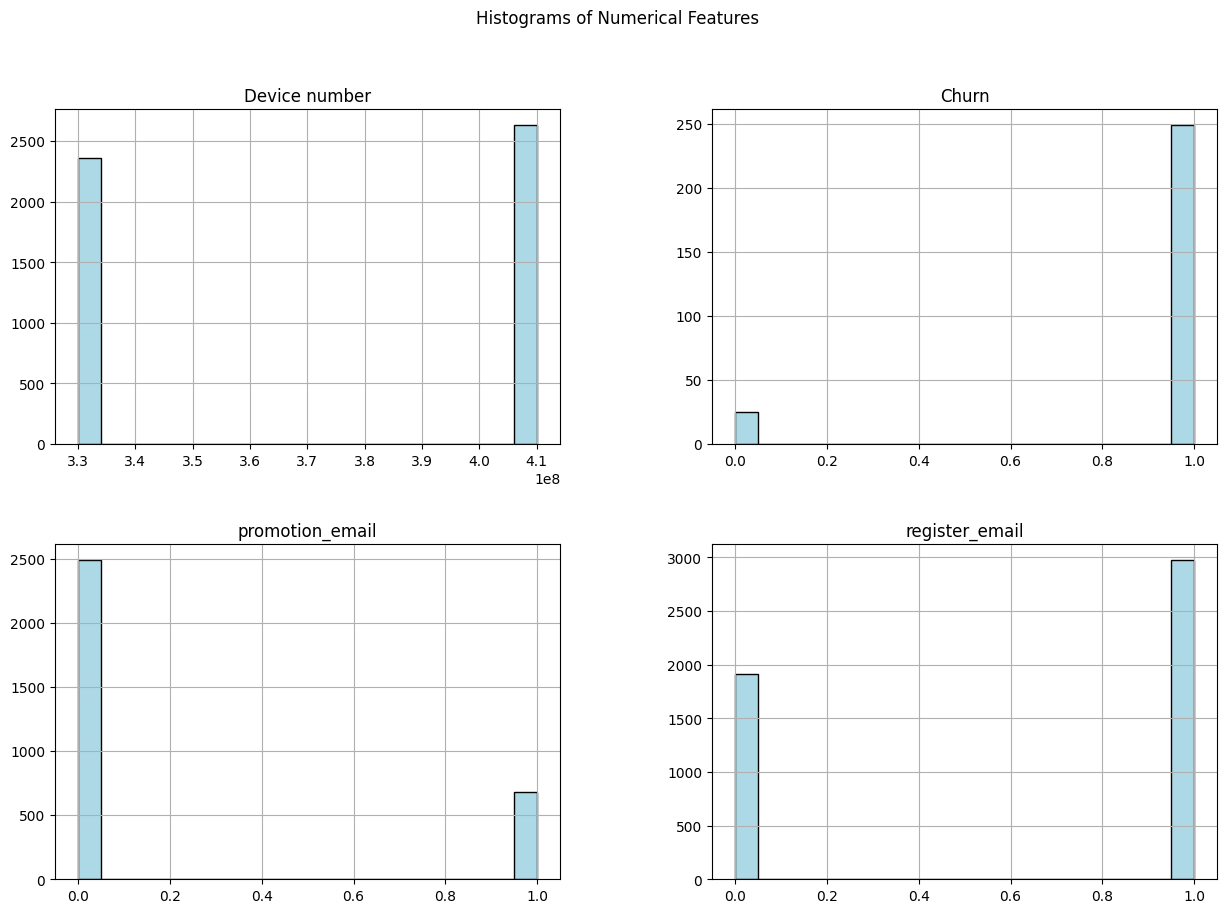

In [42]:
# Plot histograms for numerical features
data[numerical_features].hist(bins=20, figsize=(15, 10), color='lightblue', edgecolor='black')
plt.suptitle('Histograms of Numerical Features')
plt.show()

                 Device number     Churn  promotion_email  register_email
Device number         1.000000  0.277954        -0.052298       -0.477589
Churn                 0.277954  1.000000         0.058762       -0.141441
promotion_email      -0.052298  0.058762         1.000000        0.644199
register_email       -0.477589 -0.141441         0.644199        1.000000


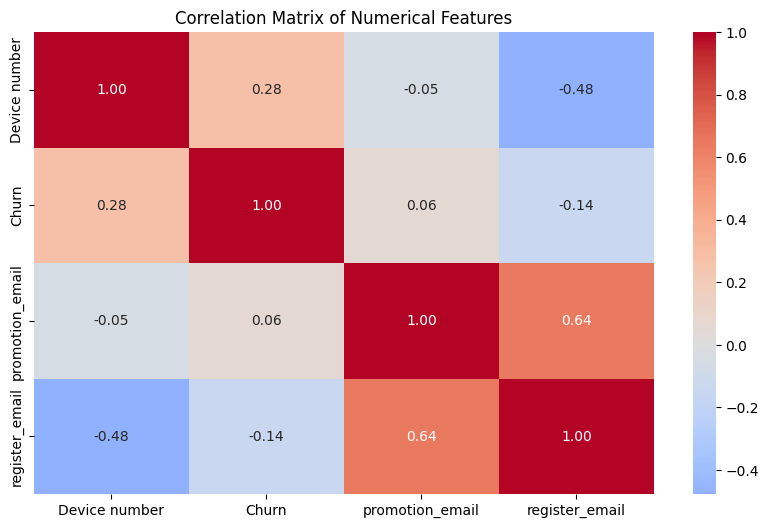

In [43]:
# correlation matrix for numerical features
corr_matrix = data[numerical_features].corr()

print(corr_matrix)

# Plotting the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title("Correlation Matrix of Numerical Features")
plt.show()

In [44]:
data['promotion_email'].describe()

count    3175.000000
mean        0.215748
std         0.411405
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: promotion_email, dtype: float64

In [45]:
# Count how many rows with Churn = 1 have promotion_email = 1
churned_with_promotion_email = data[data['Churn'] == 1]['promotion_email'].value_counts()

print(churned_with_promotion_email)

promotion_email
0.0    102
1.0     36
Name: count, dtype: int64


This suggests that a larger proportion of churned devices did not receive the promotion email

In [46]:
data['register_email'].describe()

count    4884.000000
mean        0.608313
std         0.488177
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: register_email, dtype: float64

In [47]:
# Count how many rows with Churn = 1 have promotion_email = 1
churned_with_register_email = data[data['Churn'] == 1]['register_email'].value_counts()

print(churned_with_register_email)

register_email
0.0    86
1.0    63
Name: count, dtype: int64
